##  Описание данных
Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

##  Загрузка библиотек

In [3]:
!pip install lightgbm -q
! pip install --upgrade scikit-learn -q

In [4]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
#Стиль графиков
sns.set_theme(style = 'whitegrid')
#Установка размера графика по умолчанию
from pylab import rcParams
rcParams['figure.figsize'] = 15,7

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV,
                                     TimeSeriesSplit)
from sklearn.metrics import mean_squared_error as mse, root_mean_squared_error

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor,  DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor

from time import time

# создание констант для моделей
import random
RANDOM_STATE = 20240628

TEST_SIZE = 0.1
random.seed(RANDOM_STATE)

# Установка опции для отображения максимальной ширины столбца
pd.set_option('display.max_colwidth', None)

## Загрузка и подготовка данных

In [6]:
def get_data_info(data):
    display(data.sample(5))
    display(data.describe(include='all'))
    data.info()

In [7]:
#Загрузка датафреймов 
# Тренировочная выборка
try:
    data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [8]:
get_data_info(data)

,num_orders
datetime,
2018-05-14 04:30:00,9
2018-08-13 18:30:00,7
2018-04-28 06:10:00,3
2018-04-04 14:00:00,9
2018-05-16 20:10:00,9


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [9]:
# сортировка индекса и проверка монотонности
data.sort_index(inplace=True)
data.index.is_monotonic_increasing

True

In [10]:
# ресемлирование данных по часу
data = data.resample('h').sum()

In [11]:
def lineplot(data, title):
    data.plot()
    plt.title(title)
    plt.show()

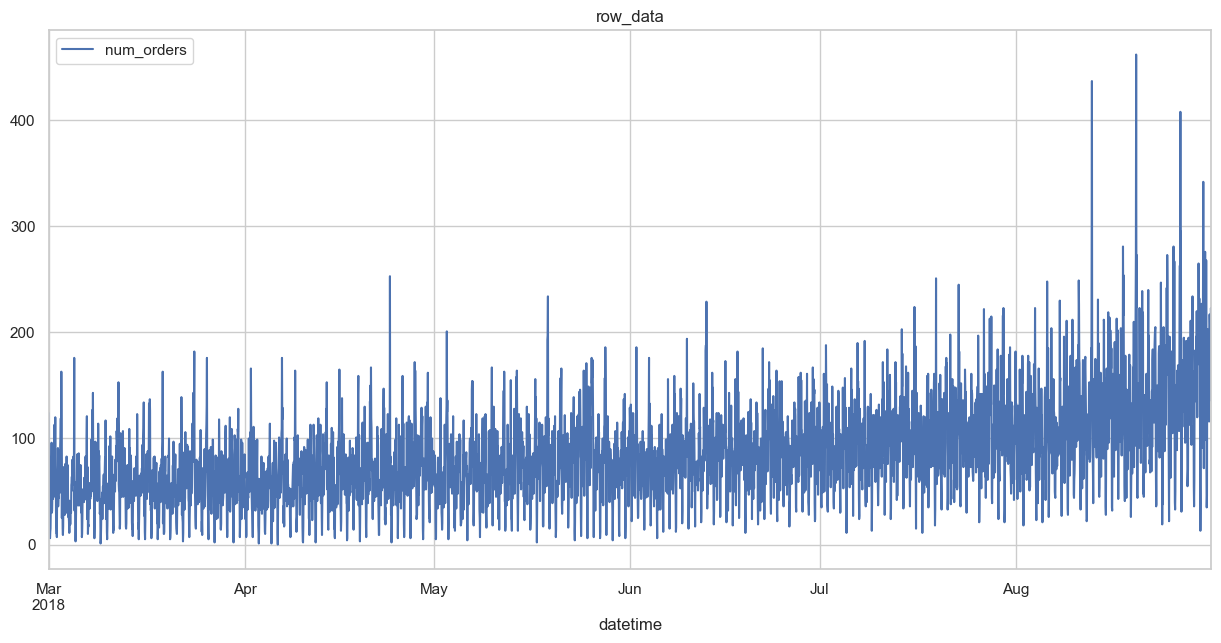

In [12]:
lineplot(data, 'row_data')

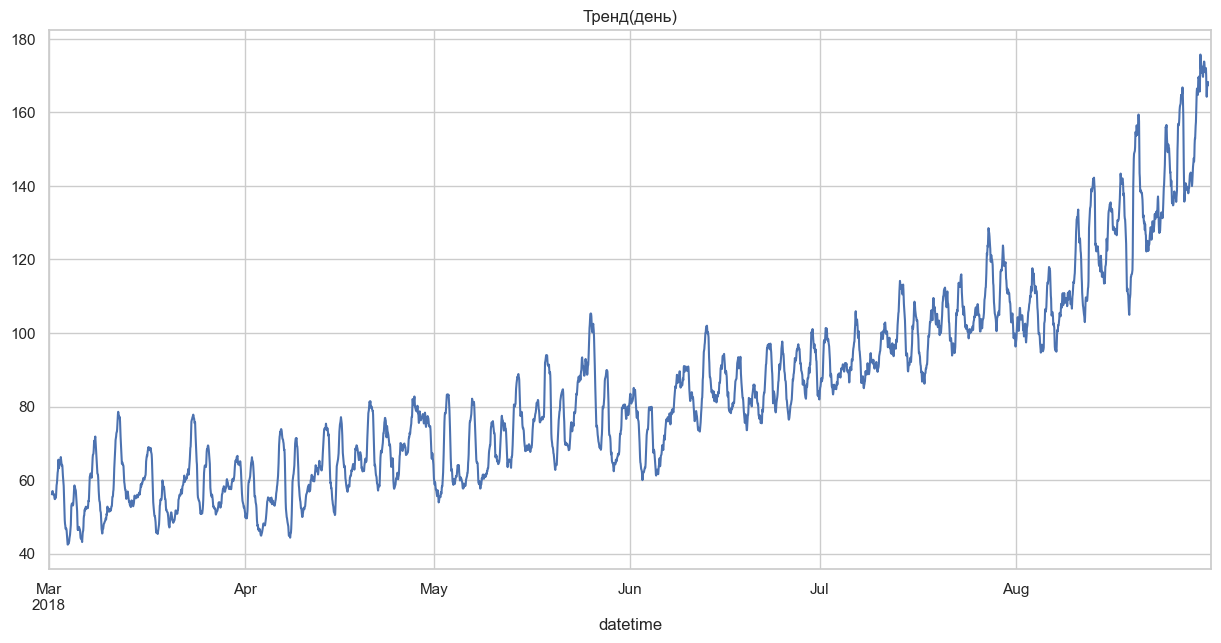

In [13]:
decomposed = seasonal_decompose(data)
lineplot(decomposed.trend, 'Тренд(день)')

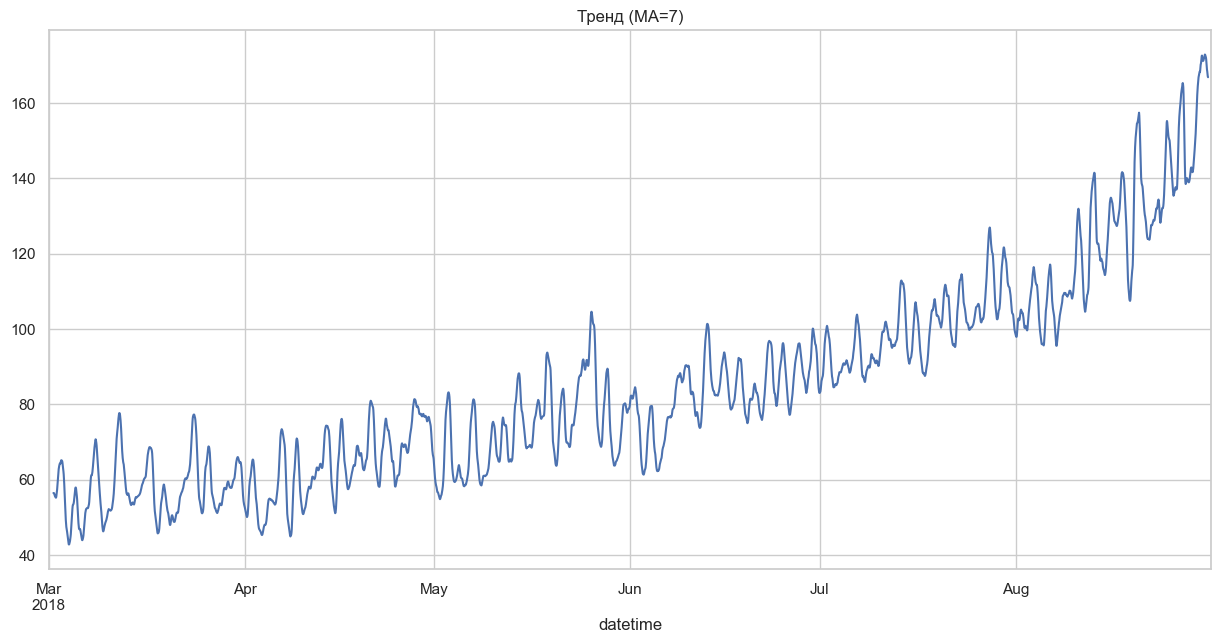

In [14]:
lineplot(decomposed.trend.rolling(7).mean(), 'Тренд (MA=7)')

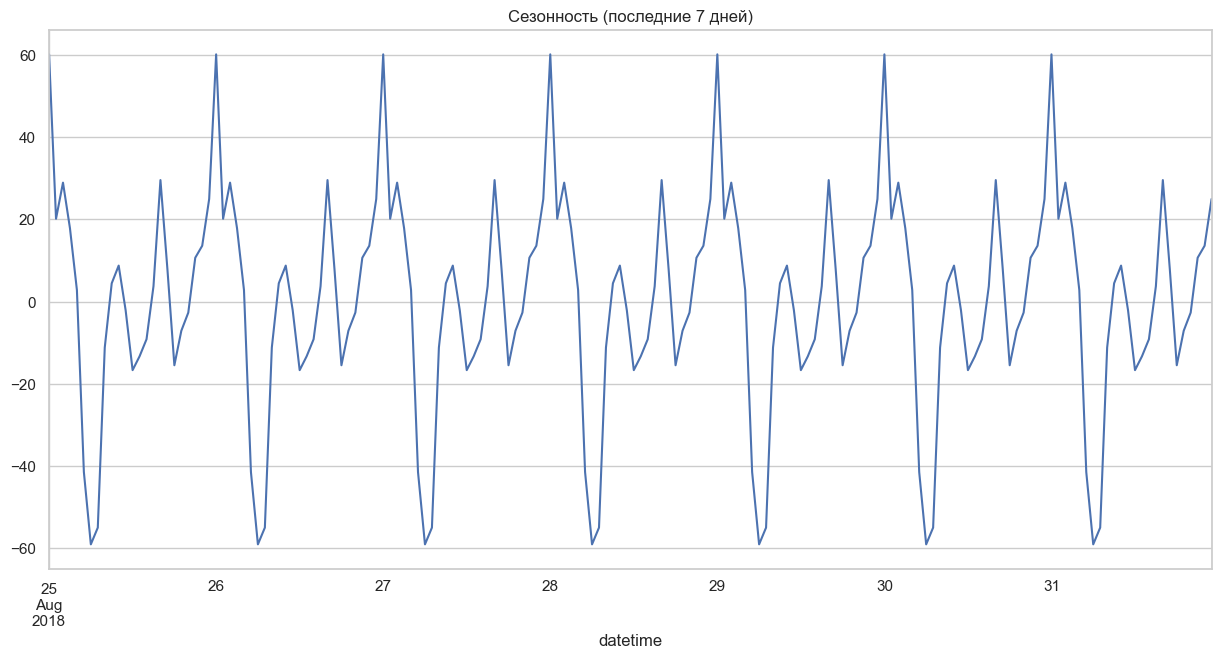

In [15]:
# 
lineplot(decomposed.seasonal.tail(24*7), 'Сезонность (последние 7 дней)')

In [16]:
# ресемлирование данных по часу
week = data.resample('D').sum()

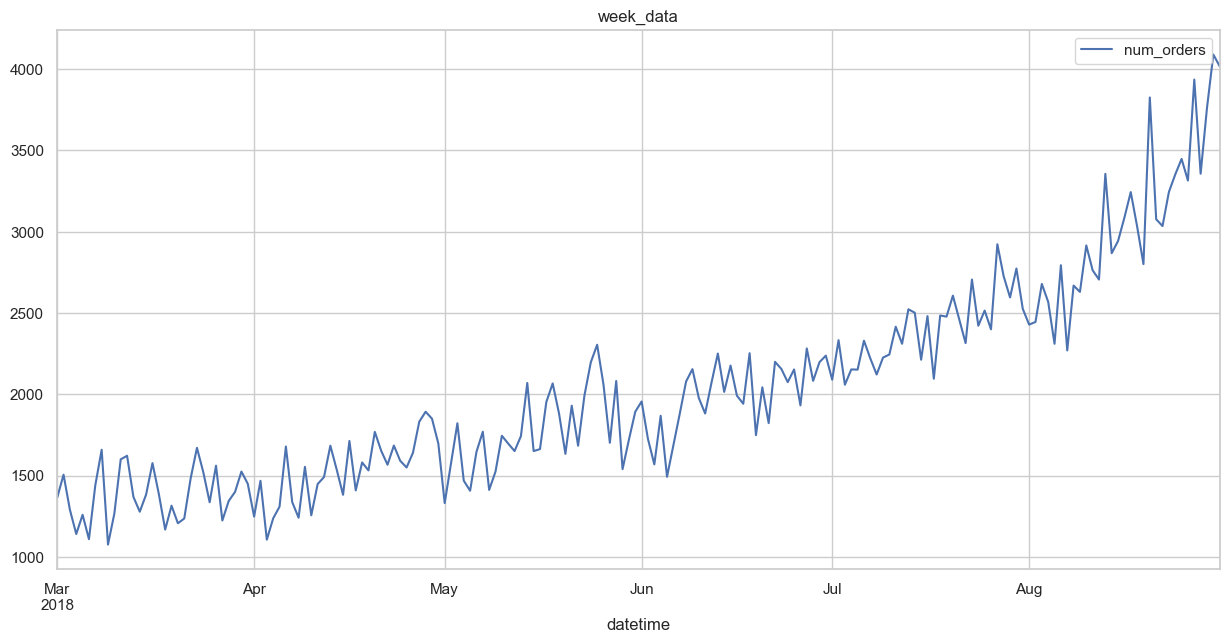

In [17]:
lineplot(week, 'week_data')

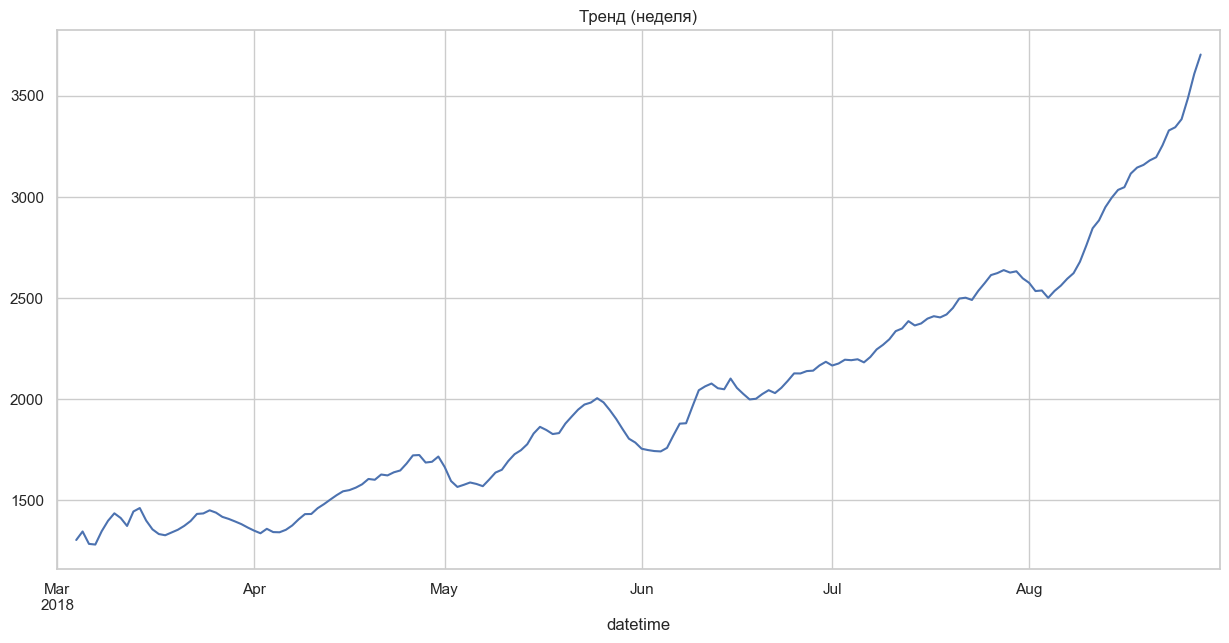

In [18]:
decomposed_week = seasonal_decompose(week)
lineplot(decomposed_week.trend, 'Тренд (неделя)')

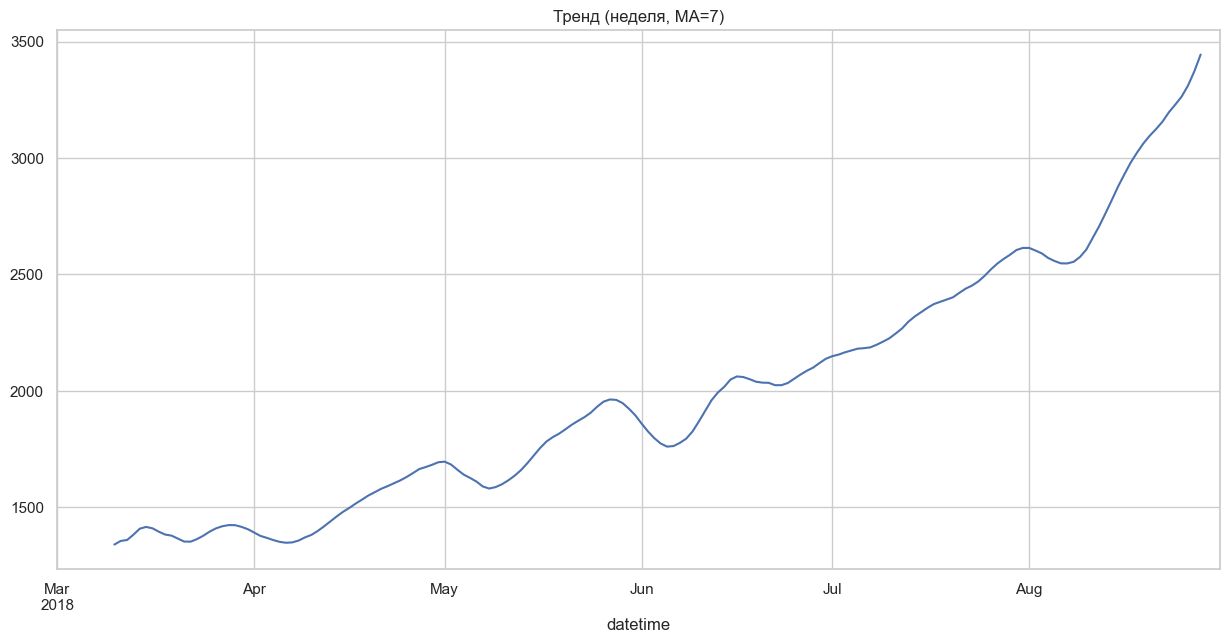

In [19]:
lineplot(decomposed_week.trend.rolling(7).mean(), 'Тренд (неделя, MA=7)')

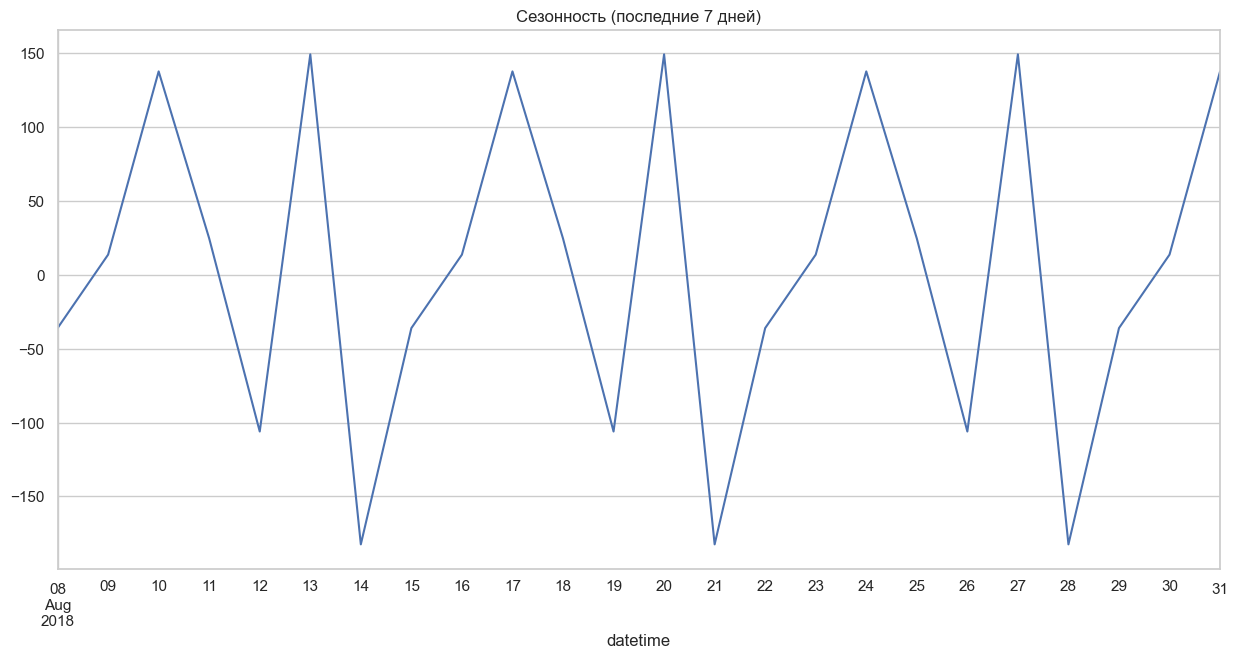

In [20]:
# 
lineplot(decomposed_week.seasonal.tail(24), 'Сезонность (последние 7 дней)')

### Вывод:

По графикам можно сделать следующие выводы:

    Наблюдается равномерный рост количества заказов по тренду с периодическими небольшими падениями. Это может указывать на постепенное увеличение спроса или развитие бизнеса в данной области.
    На графике сезонности по дням наблюдаетсяснижение количества заказов до минимуму в ночное время, затем рост с утра и в течение дня, достигая пика вечером. Это указывает на влияние времени суток и поведения потребителей на количество заказов.
    Эти наблюдения могут быть полезны при прогнозировании и планировании количества заказов в будущем, а также при принятии решений по оптимизации и управлению предприятием.

## Обучение

### Подготовка данных

In [24]:
def make_features(data, max_lag, rolling_mean_size):
#     data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)
    
    return data

In [25]:
data_learn = data.copy()
data_learn = make_features(data_learn, 24, 24)
get_data_info(data_learn)

,num_orders,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-17 01:00:00,173,4,213.0,123.0,143.0,121.0,89.0,103.0,111.0,191.0,...,145.0,120.0,32.0,35.0,121.0,185.0,166.0,187.0,185.0,129.083333
2018-05-31 10:00:00,73,3,91.0,71.0,17.0,6.0,48.0,142.0,92.0,101.0,...,53.0,88.0,106.0,59.0,56.0,89.0,82.0,73.0,77.0,80.333333
2018-05-12 22:00:00,58,5,57.0,73.0,75.0,42.0,69.0,88.0,113.0,77.0,...,13.0,40.0,41.0,110.0,163.0,66.0,145.0,119.0,95.0,72.333333
2018-04-29 18:00:00,65,6,52.0,130.0,85.0,62.0,62.0,52.0,76.0,76.0,...,112.0,83.0,129.0,107.0,116.0,74.0,98.0,88.0,65.0,77.666667
2018-06-27 14:00:00,75,2,96.0,89.0,99.0,97.0,92.0,102.0,31.0,35.0,...,100.0,79.0,73.0,82.0,83.0,104.0,117.0,102.0,73.0,93.125000


,num_orders,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
count,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,...,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000
mean,84.573543,3.005464,84.540073,84.515027,84.493852,84.472678,84.451958,84.421448,84.382058,84.346995,...,84.152322,84.145264,84.140027,84.123634,84.072404,84.064891,84.028689,84.003871,83.969262,84.257153
std,45.050123,1.996117,45.015225,44.968748,44.955561,44.944716,44.941932,44.904187,44.863722,44.835856,...,44.723919,44.732387,44.739487,44.754926,44.673101,44.673365,44.619468,44.588590,44.498432,26.308289
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,42.375000
25%,54.000000,1.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,...,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,63.666667
50%,78.000000,3.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,...,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,79.708333
75%,108.000000,5.000000,108.000000,108.000000,107.250000,107.000000,107.000000,107.000000,107.000000,107.000000,...,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,99.802083
max,462.000000,6.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,...,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,176.916667


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4392 non-null   int64  
 1   dayofweek     4392 non-null   int32  
 2   lag_1         4392 non-null   float64
 3   lag_2         4392 non-null   float64
 4   lag_3         4392 non-null   float64
 5   lag_4         4392 non-null   float64
 6   lag_5         4392 non-null   float64
 7   lag_6         4392 non-null   float64
 8   lag_7         4392 non-null   float64
 9   lag_8         4392 non-null   float64
 10  lag_9         4392 non-null   float64
 11  lag_10        4392 non-null   float64
 12  lag_11        4392 non-null   float64
 13  lag_12        4392 non-null   float64
 14  lag_13        4392 non-null   float64
 15  lag_14        4392 non-null   float64
 16  lag_15        4392 non-null   float64
 17  lag_16        4392 non-null

### Разделение на выборки

In [27]:
features = data_learn.drop(['num_orders'], axis=1) # выделение признаков
target = data_learn['num_orders']

In [28]:
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    shuffle=False,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE)

### Обучение моделей

In [30]:
# Разделение временных рядов
time_cv = TimeSeriesSplit(n_splits=5)

In [31]:
def fit_model(estimator, param_grid, features_train, target_train, features_test, target_test, n_jobs):
    '''
    функция для тренировки моделей и подбора гиперпараметров методом GridSearchCV
    '''
    model = GridSearchCV(estimator=estimator,
                         param_grid=param_grid,
                         n_jobs=n_jobs,
                         cv=time_cv,
                         verbose=False,
                         scoring='neg_root_mean_squared_error'
                         )

    start_time = time()
    model.fit(features_train, target_train)
    end_time = time()
    training_time = end_time - start_time

    best_rmse = abs(round(model.best_score_, 1))

    print(f'Best RMSE: {best_rmse}')
    print(f'Best params: {model.best_params_}')

    best_model = estimator.set_params(**model.best_params_)

    start_time = time()
    best_model.fit(features_train, target_train)
    end_time = time()
    prediction_time = end_time - start_time

    predictions_train = best_model.predict(features_train)
    train_rmse = mse(target_train, predictions_train)** 0.5

    return best_model, best_rmse, training_time, prediction_time, train_rmse

In [32]:
# датафрейм для сохранения и сравнения результатов работы моделей
results_df = pd.DataFrame(columns=['Model', 'Best RMSE', 'Training Time', 'Prediction Time'])

#### Линейная регрессия

In [34]:
best_model, best_rmse, training_time, \
prediction_time, train_rmse_LR = fit_model(LinearRegression(), 
            [{'fit_intercept': [True, False]},
             {'copy_X': [True, False]}, {'n_jobs': [1, -1]}], 
            features_train,
            target_train,
            features_test,
            target_test, -1)

best_model_lr=best_model

results_df.loc[0] = ['LinearRegression', best_rmse, training_time, prediction_time]
results_df.sort_values('Best RMSE', ascending=True)

Best RMSE: 27.1
Best params: {'fit_intercept': False}


,Model,Best RMSE,Training Time,Prediction Time
0,LinearRegression,27.1,2.733354,0.004003


#### Линейная регрессия в.2

In [36]:
scaler = StandardScaler()

features_train_scaled = scaler.fit_transform(features_train)



In [37]:
best_model, best_rmse, training_time, \
prediction_time, train_rmse_LR = fit_model(LinearRegression(), 
            [{'fit_intercept': [True, False]},
             {'copy_X': [True, False]}, {'n_jobs': [1, -1]}], 
            features_train_scaled,
            target_train,
            features_test,
            target_test, -1)

best_model_lr=best_model

results_df.loc[0] = ['LinearRegression', best_rmse, training_time, prediction_time]
results_df.sort_values('Best RMSE', ascending=True)

Best RMSE: 27.2
Best params: {'fit_intercept': True}


,Model,Best RMSE,Training Time,Prediction Time
0,LinearRegression,27.2,0.099586,0.003204


#### DecisionTreeRegressor

In [39]:
best_model, best_rmse, training_time, prediction_time, train_rmse_DTR = fit_model(
    DecisionTreeRegressor(random_state=RANDOM_STATE),
    {'max_depth': range(1, 11, 2)},
    features_train,
    target_train,
    features_test,
    target_test,
-1)

best_model_dtr=best_model

results_df.loc[1] = ['DecisionTreeRegressor', best_rmse, training_time, prediction_time]
results_df.sort_values('Best RMSE', ascending=True)

Best RMSE: 30.3
Best params: {'max_depth': 5}


,Model,Best RMSE,Training Time,Prediction Time
0,LinearRegression,27.2,0.099586,0.003204
1,DecisionTreeRegressor,30.3,0.231134,0.026990


#### RandomForestRegressor

In [41]:
best_model, best_rmse, training_time, \
prediction_time, train_rmse_RFR = fit_model(RandomForestRegressor(random_state=RANDOM_STATE), 
            {'n_estimators': range(50, 100, 10), 'max_depth': range(1, 11, 2)}, 
            features_train,
            target_train,
            features_test,
            target_test, -1)

best_model_rfr=best_model

results_df.loc[2] = ['RandomForestRegressor', best_rmse, training_time, prediction_time]

results_df.sort_values('Best RMSE', ascending=True)

Best RMSE: 26.2
Best params: {'max_depth': 9, 'n_estimators': 70}


,Model,Best RMSE,Training Time,Prediction Time
2,RandomForestRegressor,26.2,21.021356,2.444207
0,LinearRegression,27.2,0.099586,0.003204
1,DecisionTreeRegressor,30.3,0.231134,0.026990


#### LightGBM

In [43]:
best_model, best_rmse, training_time, \
prediction_time, train_rmse_lgb = fit_model(LGBMRegressor(random_state=RANDOM_STATE), 
            {'n_estimators': range(50, 100, 10),
             'max_depth': range(1, 11, 2)}, 
            features_train,
            target_train,
            features_test,
            target_test, 1)

best_model_lgb=best_model

results_df.loc[3] = ['LGBMRegressor', best_rmse, training_time, prediction_time]

results_df.sort_values('Best RMSE', ascending=True)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2665
[LightGBM] [Info] Number of data points in the train set: 662, number of used features: 26
[LightGBM] [Info] Start training from score 57.057402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

,Model,Best RMSE,Training Time,Prediction Time
3,LGBMRegressor,25.6,4.659668,0.041013
2,RandomForestRegressor,26.2,21.021356,2.444207
0,LinearRegression,27.2,0.099586,0.003204
1,DecisionTreeRegressor,30.3,0.231134,0.026990


In [44]:
best_model_lgb

LGBMRegressor(max_depth=5, n_estimators=90, random_state=20240628)

#### Промежуточный вывод:

Была проведена разбивка данных на выборки. Создана функция fit_model(), которая методом GridSearchCV подбирает наилучшую модели и выводит метрику RMSE и параметры лучшей модели. 
Были обучены 4 модели (DecisionTreeRegressor, RandomForestRegressor, LinearRegression, LGBMRegressor). 
Метрики RMSE, время обучения и предсказания для каждой из этих моделей собраны в виде таблицы.

По результатам можно сделать вывод что лучшей моделью стала модель LGBMRegressor с Best RMSE на кросс-валидации = 25.6



### Тестирование моделей
Проведем тест обученных моделей на тестовых данных, добавим их RMSE в датафрейм с результатами, построим графики исходного и предсказанных рядов для каждой модели

In [47]:
def display_result(target, pred, rmse):
    result = target.to_frame().reset_index()
    result['prediction'] = pd.Series(pred)
    result.set_index('datetime', inplace=True)
    
    lineplot(result, 'RMSE='+str(rmse))

In [48]:
best_models = [
               best_model_lgb
              ]

In [49]:
test_models = []

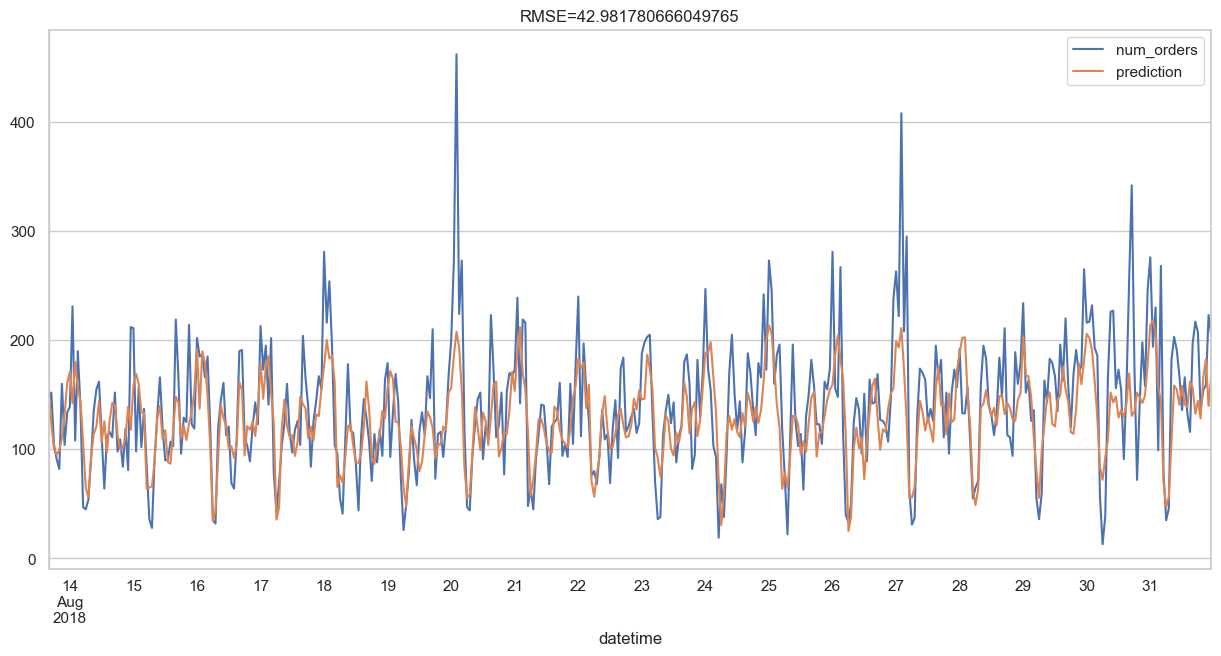

In [50]:
test_models
for i in best_models:
    predictions = i.predict(features_test)
    rmse = mse(target_test, predictions)**0.5
    display_result(target_test, predictions, rmse)
    test_models.append(rmse)

In [51]:

predictions = best_model_lgb.predict(features_test)

best_rmse = root_mean_squared_error(target_test, predictions)

In [52]:
best_result = pd.DataFrame(columns=["Model", 'Best RMSE'])
best_result.loc[0] = ['LightGBM', round(best_rmse,2)]

In [53]:
best_result

,Model,Best RMSE
0,LightGBM,42.98


## Вывод

Было проведено исследование, направленное на создание модели машинного обучения для прогнозирования количества заказов для компании «Чётенькое такси»  в аэропортах на следующий час. 

Исследование проведено в целях привлечения большего количества водителей к аэропортам в периоды пиковой нагрузки. Входные данные для модели - исторические данные о заказах такси в аэропортах. Результаты на обучающей и тнстовой выборках показали, что удалось создать модель для успешного прогнозирования. Лучшей моделью является  LGBMRegressor
